In [122]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import pyproj
from skimage.filters import roberts, sobel, scharr, prewitt
from scipy import stats
%matplotlib inline

In [13]:
LL_WGS84 = pyproj.Proj(proj='latlong',datum='WGS84',errcheck=True)
SPCS_N_OR = pyproj.Proj(init = 'nad27:3601')

In [14]:
def convertCoords(x, y):
    '''Converts model coordinaates x, y from spcs to lon/lat'''
    lon_mod, lat_mod = pyproj.transform(SPCS_N_OR, LL_WGS84, x, y)
    return lon_mod, lat_mod

In [15]:
def getMonthSatRegion(filen, lonmin, lonmax, latmin, latmax):
    '''Extracts a particular region of interest from the satellite data.
    Arguments include the filename, min and max longitude, and min and max
    latitude.
    Assumes a monthly dataset, with only one record.
    Longitude inputs should be in range of -155:-105, and latitude inputs
    should be in range of 22:51'''

    fn = nc.Dataset(filen,'r')

    # Read in the variables of interest.
    lon = fn.variables['lon'][:]
    lat = fn.variables['lat'][:]
    MWsstd = fn.variables['MWsstd'][0]

    # Make correction to longitude
    lon = lon - 360.0
    idx_lon = np.array(np.where((lon > lonmin) & (lon < lonmax)))
    idx_lat = np.array(np.where((lat > latmin) & (lat < latmax)))

    lon_min = idx_lon.min()
    lon_max = idx_lon.max()
    lat_min = idx_lat.min()
    lat_max = idx_lat.max()

    lon_sat = lon[lon_min:lon_max]
    lat_sat = lat[lat_min:lat_max]
    sst_sat = MWsstd[0, lat_min:lat_max, lon_min:lon_max]

    return lon_sat, lat_sat, sst_sat

In [22]:
def readSELFEslab(fn):
    fn = nc.Dataset(fn,'r')
    x = fn.variables['x'][:]
    y = fn.variables['y'][:]
    conn = fn.variables['connectivity'][:]
    temp = fn.variables['water_temperature'][:]
    [lon_mod, lat_mod] = convertCoords(x, y)
    triang = tri.Triangulation(lon_mod, lat_mod, conn)
    
    return lon_mod, lat_mod, temp, triang

In [23]:
def month_avg(data):
    data_mean = np.nanmean(data, axis = 1)
    return data_mean

In [24]:
def interpolateSELFE(triang,data,lon_sat,lat_sat):
    """Interpolates the SELFE data set to the same grid as the satellite data
        grid
    """
    interp = tri.LinearTriInterpolator(triang, data)
    xx,yy = np.meshgrid(lon_sat, lat_sat)
    mod_interp = interp(xx,yy)
    return mod_interp

In [25]:
def load_coast(file_name):
    data = np.loadtxt(file_name)
    coast_x = data[:,0]
    coast_y = data[:,1]
    return coast_x, coast_y

In [26]:
def plume_region(lon, lat, data):
    idx_lon = np.array(np.where((lon > -125.2) & (lon < -123.3)))
    idx_lat = np.array(np.where((lat > 45) & (lat < 47)))
    lon_min = idx_lon.min()
    lon_max = idx_lon.max()
    lat_min = idx_lat.min()
    lat_max = idx_lat.max()
    lon_plume = lon[lon_min:lon_max]
    lat_plume = lat[lat_min:lat_max]
    data_plume = data[lat_min:lat_max, lon_min:lon_max]

    return lon_plume, lat_plume, data_plume

In [27]:
def plume_edges(data,type):
    ''' Where type is a type of filter for the canny edge
    '''    
    data = data.astype(float)    
    edge_data = type(np.flipud(data))
    return edge_data

In [4]:
ls SST_sat_data/

MW2005001_2005031_sstd.nc  MW2005182_2005212_sstd.nc
MW2005032_2005059_sstd.nc  MW2005213_2005243_sstd.nc
MW2005060_2005090_sstd.nc  MW2005244_2005273_sstd.nc
MW2005091_2005120_sstd.nc  MW2005274_2005304_sstd.nc
MW2005121_2005151_sstd.nc  MW2005305_2005334_sstd.nc
MW2005152_2005181_sstd.nc  MW2005335_2005365_sstd.nc


In [82]:
# Read in coastline for model domain
[coast_x, coast_y] = load_coast('coastline.dat')

# Data Extraction
Here I am extracting variables from the satellite data and the model data. The satellite data is a monthly average, and the model data includes temperatures for each point at the surface of the domain for an entire month, with a time step of 15 minutes. Thus, this data set will need additional processing before it may be compared with the satellite data.

In [77]:
# Extract data from the model, including x, y, temperature, and triang (variable that stores the x, y, and connectivity of nodes)
[lon_mod,lat_mod,temp1,triang]=readSELFEslab('SELFE_slabs/slab_temp_s-1_2005-07-01_2005-08-01.nc')

In [65]:
# Extract satellite data, variables include longitude, latitude, and sea surface temperature. 
[lon_sat, lat_sat, sst_July] = getMonthSatRegion('SST_sat_data/MW2005182_2005212_sstd.nc',
                                                min(lon_mod),max(lon_mod),min(lat_mod),max(lat_mod))

In [78]:
# Calculate monthly average for model data and interpolate to satellite grid
temp_July = month_avg(temp1)
temp_mod_interp_July = interpolateSELFE(triang, temp_July, lon_sat, lat_sat)

/Users/kmorrice/anaconda/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


# Plotting of Figures
Before I begin doing further analysis on my model and satellite data, I would like to see what my data look like, and note the general differences between the satellite and model data. 

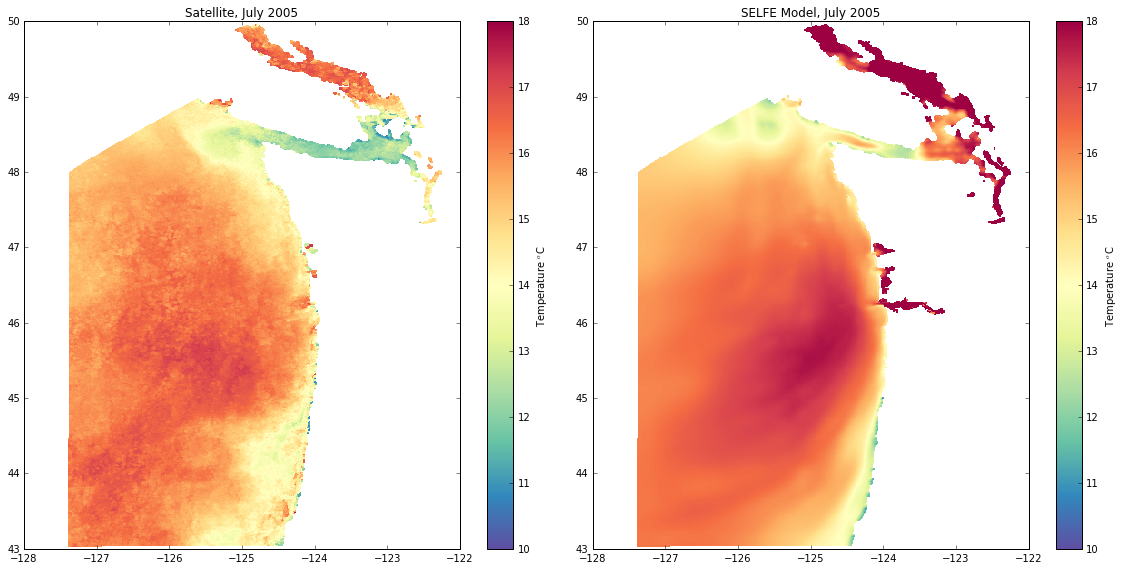

In [91]:
# First mask satellite values that are not part of model domain
sst_July_m = np.ma.masked_where(np.ma.getmask(temp_mod_interp_July),sst_July)

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
p1 = plt.pcolor(lon_sat, lat_sat, sst_July_m, vmin = 10, vmax = 18, cmap = 'Spectral_r')
plt.colorbar(p1,label='Temperature $^o$C')
plt.title('Satellite, July 2005')

plt.subplot(1,2,2)
p2 = plt.pcolor(lon_sat, lat_sat, temp_mod_interp_July, vmin = 10, vmax = 18, cmap = 'Spectral_r')
plt.colorbar(p2, label= 'Temperature $^o$C')
plt.title('SELFE Model, July 2005')
plt.tight_layout()

(10, 26)

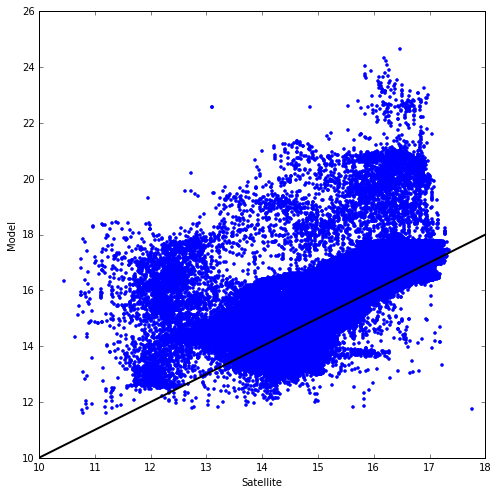

In [61]:
plt.figure(figsize=(8,8))
plt.plot(sst_sat,temp_mod_interp,'.b')
plt.xlabel('Satellite')
plt.ylabel('Model')
plt.plot([10, 26],[10,26],color='k',linestyle='-',linewidth=2)
plt.xlim(10,18)
plt.ylim(10,26)

In [128]:
# Extract data for plume region
[lon_plume,lat_plume,sat_plume_July] = plume_region(lon_sat,lat_sat,sst_July)
[lon_plume,lat_plume,mod_plume_July] = plume_region(lon_sat,lat_sat,temp_mod_interp_July)

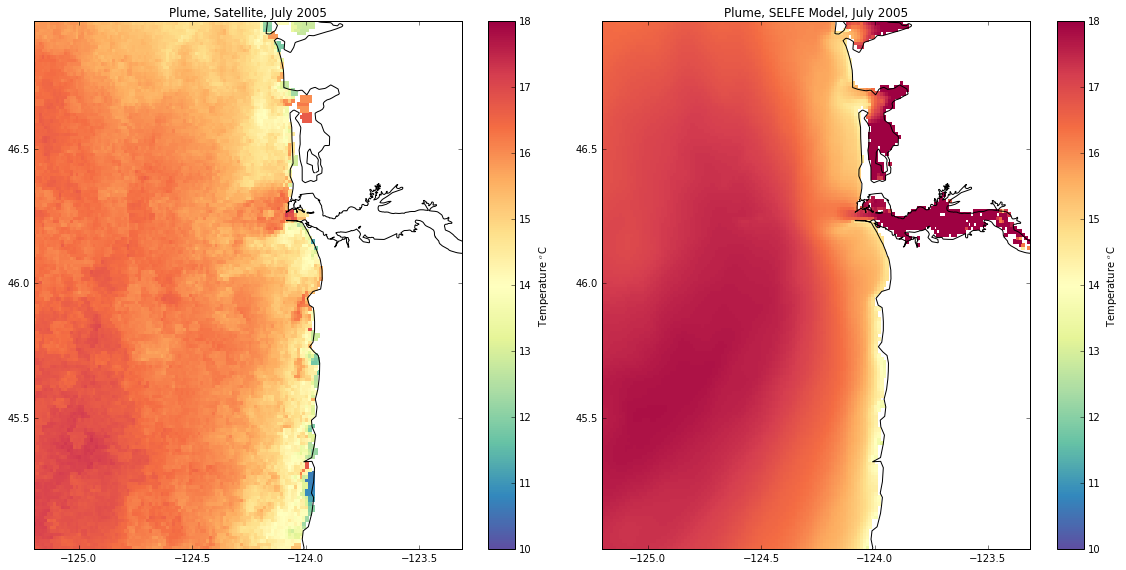

In [129]:
# Plot plume region
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
p1 = plt.pcolor(lon_plume, lat_plume, sat_plume_July, vmin = 10, vmax = 18, cmap = 'Spectral_r')
plt.colorbar(p1,label='Temperature $^o$C')
plt.plot(coast_x,coast_y,'black')
plt.xlim(min(lon_plume),max(lon_plume))
plt.ylim(min(lat_plume),max(lat_plume))
plt.title('Plume, Satellite, July 2005')

plt.subplot(1,2,2)
p2 = plt.pcolor(lon_plume, lat_plume, mod_plume_July, vmin = 10, vmax = 18, cmap = 'Spectral_r')
plt.colorbar(p2, label= 'Temperature $^o$C')
plt.plot(coast_x,coast_y,'black')
plt.xlim(min(lon_plume),max(lon_plume))
plt.ylim(min(lat_plume),max(lat_plume))
plt.title('Plume, SELFE Model, July 2005')
plt.tight_layout()

# Look at August 2005

In [80]:
# Now I would like to look at a different month
# Extract data from the model, including x, y, temperature, and triang (variable that stores the x, y, and connectivity of nodes)
[lon_mod,lat_mod,temp2,triang]=readSELFEslab('SELFE_slabs/slab_temp_s-1_2005-08-01_2005-09-01.nc')
# Extract satellite data, variables include longitude, latitude, and sea surface temperature. 
[lon_sat, lat_sat, sst_Aug] = getMonthSatRegion('SST_sat_data/MW2005213_2005243_sstd.nc',
                                                min(lon_mod),max(lon_mod),min(lat_mod),max(lat_mod))
# Calculate monthly average for model data and interpolate to satellite grid
temp_Aug = month_avg(temp2)
temp_mod_interp_Aug = interpolateSELFE(triang, temp_Aug, lon_sat, lat_sat)

/Users/kmorrice/anaconda/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


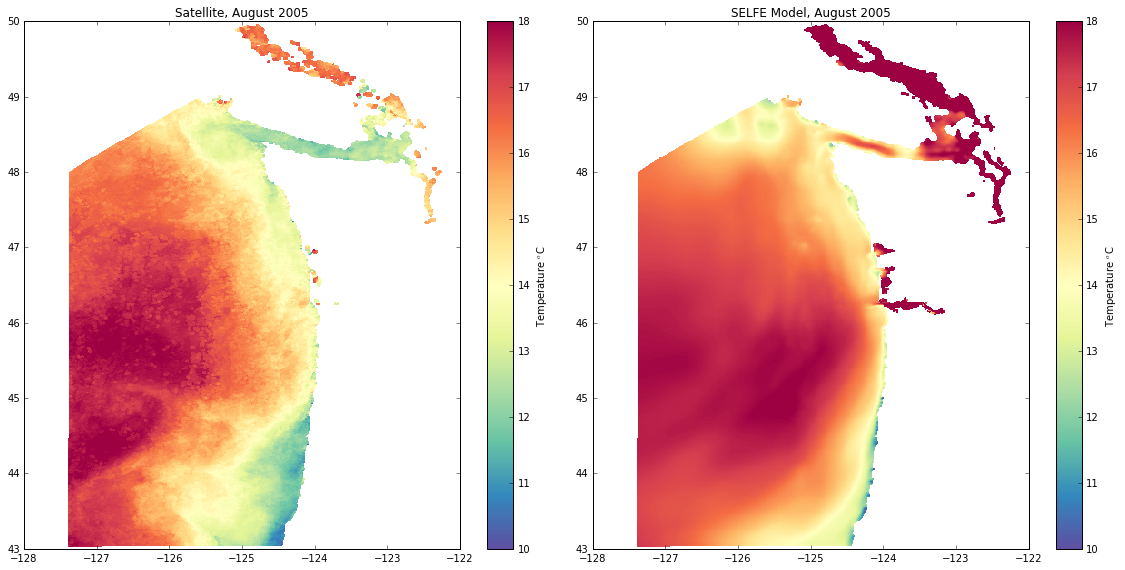

In [95]:
# First mask satellite values that are not part of model domain
sst_Aug_m = np.ma.masked_where(np.ma.getmask(temp_mod_interp_Aug),sst_Aug)
# sstmod_m = np.ma.masked_where(np.ma.getmask(sst_Aug_m),temp_mod_interp_Aug) # If I want to remove the Columbia from model

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
p1 = plt.pcolor(lon_sat, lat_sat, sst_Aug_m, vmin = 10, vmax = 18, cmap = 'Spectral_r')
plt.colorbar(p1,label='Temperature $^o$C')
plt.title('Satellite, August 2005')

plt.subplot(1,2,2)
p2 = plt.pcolor(lon_sat, lat_sat, temp_mod_interp_Aug, vmin = 10, vmax = 18, cmap = 'Spectral_r')
plt.colorbar(p2, label= 'Temperature $^o$C')
plt.title('SELFE Model, August 2005')
plt.tight_layout()

In [130]:
# Extract data for plume region
[lon_plume,lat_plume,sat_plume_Aug] = plume_region(lon_sat,lat_sat,sst_Aug)
[lon_plume,lat_plume,mod_plume_Aug] = plume_region(lon_sat,lat_sat,temp_mod_interp_Aug)

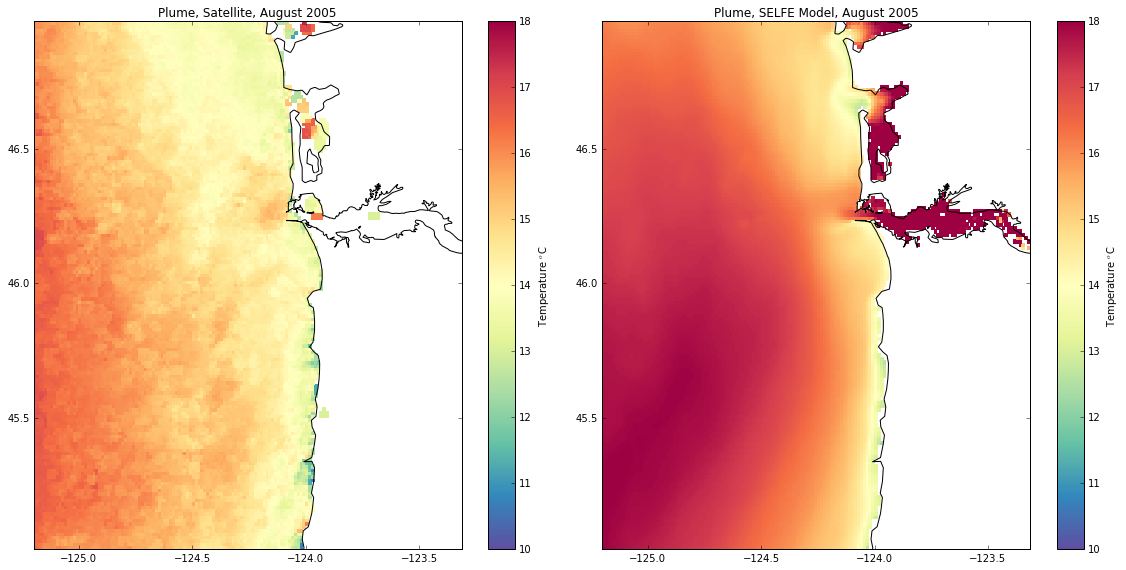

In [131]:
# Plot plume region
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
p1 = plt.pcolor(lon_plume, lat_plume, sat_plume_Aug, vmin = 10, vmax = 18, cmap = 'Spectral_r')
plt.colorbar(p1,label='Temperature $^o$C')
plt.plot(coast_x,coast_y,'black')
plt.xlim(min(lon_plume),max(lon_plume))
plt.ylim(min(lat_plume),max(lat_plume))
plt.title('Plume, Satellite, August 2005')

plt.subplot(1,2,2)
p2 = plt.pcolor(lon_plume, lat_plume, mod_plume_Aug, vmin = 10, vmax = 18, cmap = 'Spectral_r')
plt.colorbar(p2, label= 'Temperature $^o$C')
plt.plot(coast_x,coast_y,'black')
plt.xlim(min(lon_plume),max(lon_plume))
plt.ylim(min(lat_plume),max(lat_plume))
plt.title('Plume, SELFE Model, August 2005')
plt.tight_layout()

# Look at May

In [98]:
# Now I would like to look at a different month
# Extract data from the model, including x, y, temperature, and triang (variable that stores the x, y, and connectivity of nodes)
[lon_mod,lat_mod,temp3,triang]=readSELFEslab('SELFE_slabs/slab_temp_s-1_2005-05-01_2005-06-01.nc')
# Extract satellite data, variables include longitude, latitude, and sea surface temperature. 
[lon_sat, lat_sat, sst_May] = getMonthSatRegion('SST_sat_data/MW2005121_2005151_sstd.nc',
                                                min(lon_mod),max(lon_mod),min(lat_mod),max(lat_mod))
# Calculate monthly average for model data and interpolate to satellite grid
temp_May = month_avg(temp3)
temp_mod_interp_May = interpolateSELFE(triang, temp_May, lon_sat, lat_sat)

/Users/kmorrice/anaconda/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


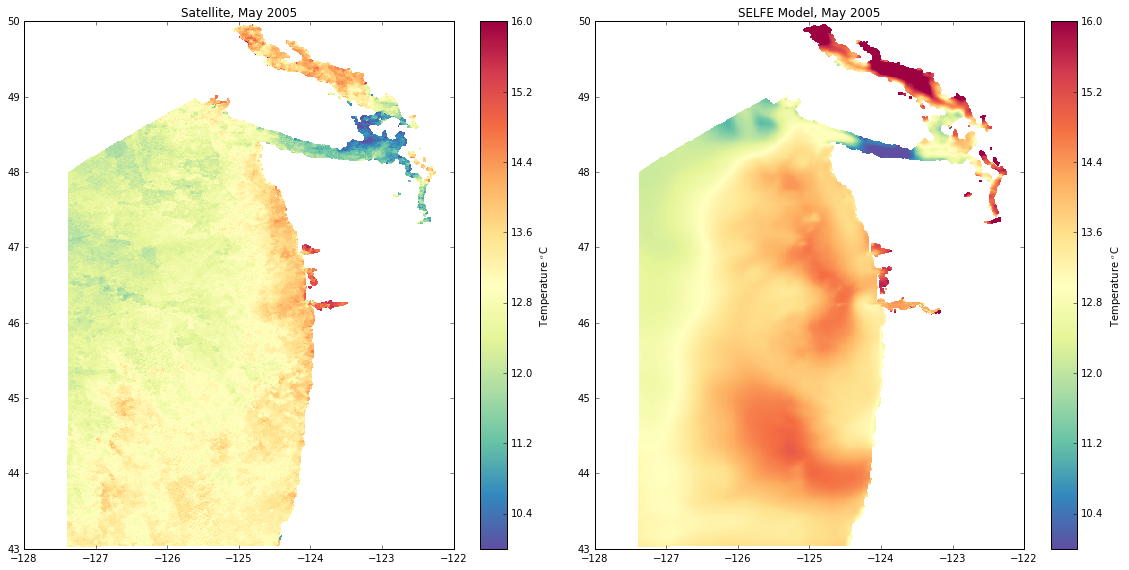

In [100]:
# First mask satellite values that are not part of model domain
sst_May_m = np.ma.masked_where(np.ma.getmask(temp_mod_interp_May),sst_May)
# sstmod_m = np.ma.masked_where(np.ma.getmask(sst_Aug_m),temp_mod_interp_Aug) # If I want to remove the Columbia from model

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
p1 = plt.pcolor(lon_sat, lat_sat, sst_May_m, vmin = 10, vmax = 16, cmap = 'Spectral_r')
plt.colorbar(p1,label='Temperature $^o$C')
plt.title('Satellite, May 2005')

plt.subplot(1,2,2)
p2 = plt.pcolor(lon_sat, lat_sat, temp_mod_interp_May, vmin = 10, vmax = 16, cmap = 'Spectral_r')
plt.colorbar(p2, label= 'Temperature $^o$C')
plt.title('SELFE Model, May 2005')
plt.tight_layout()

In [105]:
# Extract data for plume region
[lon_plume,lat_plume,sat_plume_May] = plume_region(lon_sat,lat_sat,sst_May)
[lon_plume,lat_plume,mod_plume_May] = plume_region(lon_sat,lat_sat,temp_mod_interp_May)

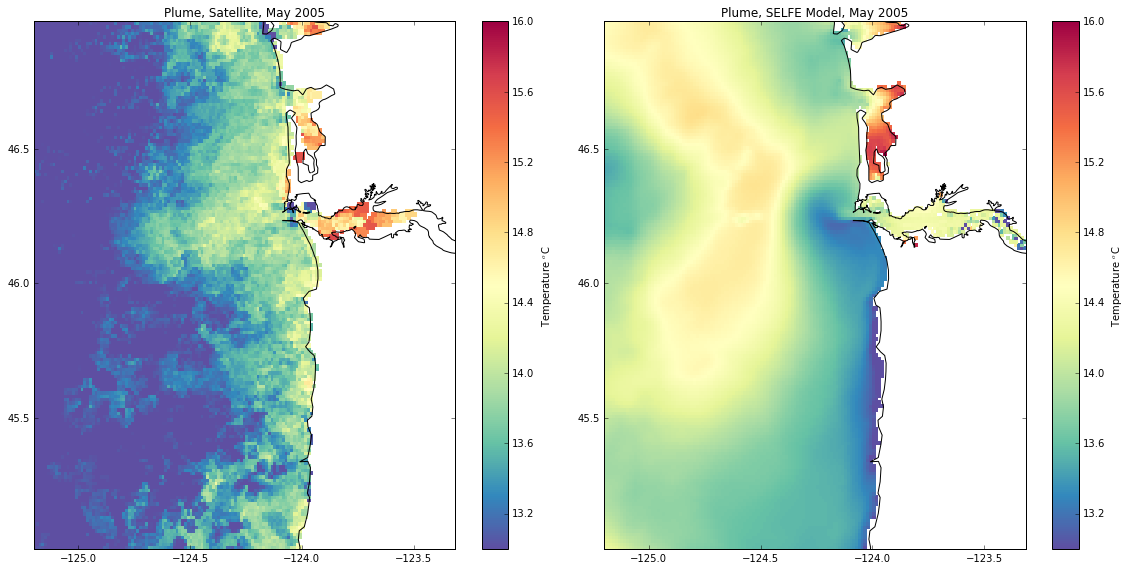

In [108]:
# Plot plume region
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
p1 = plt.pcolor(lon_plume, lat_plume, sat_plume_May, vmin = 13, vmax = 16, cmap = 'Spectral_r')
plt.colorbar(p1,label='Temperature $^o$C')
plt.plot(coast_x,coast_y,'black')
plt.xlim(min(lon_plume),max(lon_plume))
plt.ylim(min(lat_plume),max(lat_plume))
plt.title('Plume, Satellite, May 2005')

plt.subplot(1,2,2)
p2 = plt.pcolor(lon_plume, lat_plume, mod_plume_May, vmin = 13, vmax = 16, cmap = 'Spectral_r')
plt.colorbar(p2, label= 'Temperature $^o$C')
plt.plot(coast_x,coast_y,'black')
plt.xlim(min(lon_plume),max(lon_plume))
plt.ylim(min(lat_plume),max(lat_plume))
plt.title('Plume, SELFE Model, May 2005')
plt.tight_layout()

# Edge Detection

From the figures above, the plume isn't as obvious as I'd like. I had hoped to work with salinity data, but that data is not highly resolved enough. Thus, I must work with the available data set. The temperature is not ideal to detect the plume, but I will use it anyways, and try to identify a month from above where the plume is more evident. 

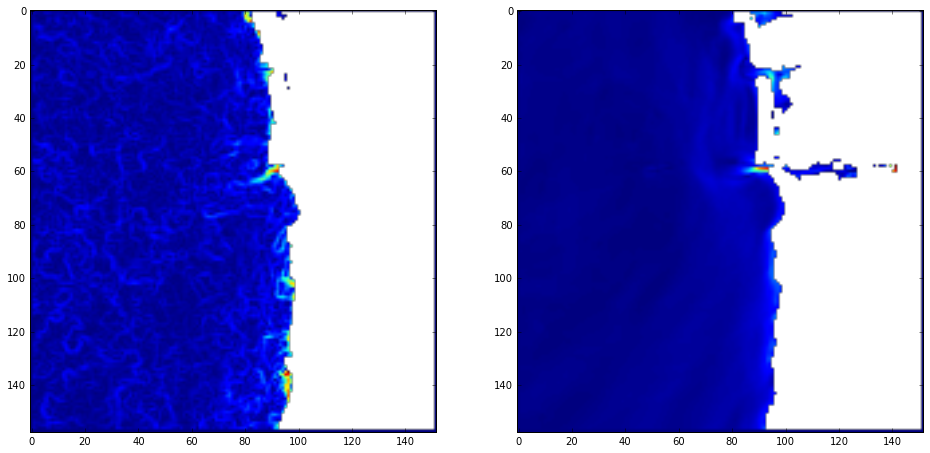

In [133]:
# First need to set empty cells to nan for satellite data
sat_plume_July1 = sat_plume_July.copy()
sat_plume_July1[np.where(sat_plume_July.mask == True)] = np.nan
July_edge_sat = plume_edges(sat_plume_July1,sobel)
July_edge_mod = plume_edges(mod_plume_July,sobel)

plt.figure(figsize = (16,8))
plt.subplot(1,2,1)
plt.imshow(July_edge_sat)

plt.subplot(1,2,2)
plt.imshow(July_edge_mod)

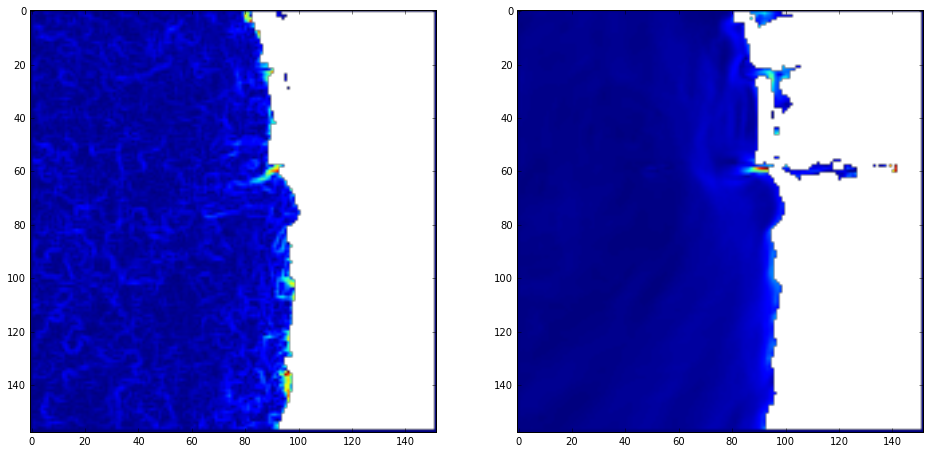

In [134]:
type = prewitt
July_edge_sat = plume_edges(sat_plume_July1,type)
July_edge_mod = plume_edges(mod_plume_July,type)

plt.figure(figsize = (16,8))
plt.subplot(1,2,1)
plt.imshow(July_edge_sat)

plt.subplot(1,2,2)
plt.imshow(July_edge_mod)
